In [1]:
%cd ..

/home/kimsin98/Adolescent/StructFunc


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

In [3]:
import statsmodels.api as sm

from utils import abcd, plotting, preprocess
ABCD_PATH = Path('inputs/ABCD')
covariates = abcd.load_covariates('outputs/abcd_covariates.csv', simple_race=True)

In [4]:
def confound_residuals(features, model, confounds, n_workers=None):
    sample = features.index.intersection(confounds.index)
    # convert to DataFrame to prevent get_dummies on numeric
    confounds = pd.DataFrame(confounds.loc[sample])
    
    if n_workers is not None:
        import mapply
        mapply.init(n_workers=n_workers, chunk_size=1, progressbar=True)
        results = features.loc[sample].mapply(preprocess.residualize,
                                              model=model, regressors=confounds,
                                              return_result=True)
    else:
        results = features.loc[sample].apply(preprocess.residualize,
                                             model=model, regressors=confounds,
                                             return_result=True)
    
    out = {}
    out['resids'] = pd.concat(list(results.iloc[0]), axis=1)
    out['results'] = results.iloc[1]
    return out

# Functional connectivity

In [5]:
fcon, fc_extra = abcd.load_mri_data(ABCD_PATH, 'fcon', dropna=True)

subs = fcon.index.get_level_values(0).unique()
print(len(subs), 'subjects')

4188 subjects


## Scanner

In [6]:
abcd.SCAN_INFO

['mri_info_manufacturer',
 'mri_info_manufacturersmn',
 'mri_info_deviceserialnumber',
 'mri_info_softwareversion']

In [7]:
# fill in some baseline NA with year2
scan = fc_extra[abcd.SCAN_INFO].join(covariates['site_id']).fillna(method='bfill')

### Progressive residualize

Residualize each scanner confound one by one

In [10]:
residresults = {}

curr_features = fcon
for scan_conf in abcd.SCAN_INFO:
    residresults[scan_conf] = confound_residuals(curr_features, sm.OLS, scan[scan_conf])
    curr_features = residresults[scan_conf]['resids']

/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mean: 0.0142, max: 0.1003


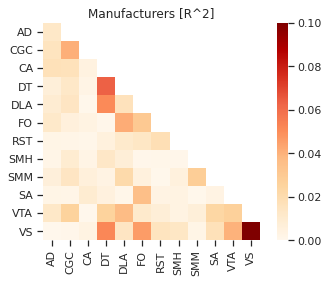

In [15]:
r2s = residresults['mri_info_manufacturer']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Manufacturers [R^2]')
plt.show()

mean: 0.0020, max: 0.0087


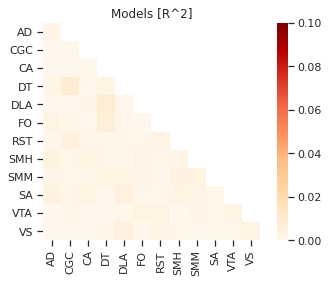

In [16]:
r2s = residresults['mri_info_manufacturersmn']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Models [R^2]')
plt.show()

mean: 0.0145, max: 0.0464


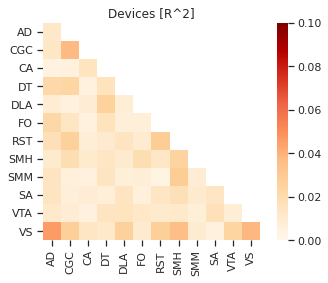

In [17]:
r2s = residresults['mri_info_deviceserialnumber']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Devices [R^2]')
plt.show()

mean: 0.0023, max: 0.0114


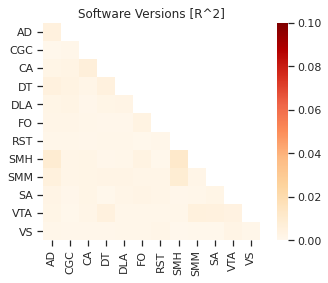

In [18]:
r2s = residresults['mri_info_softwareversion']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Software Versions [R^2]')
plt.show()

### Specific variables

#### SIEMENS

In [24]:
siemens_idx = scan['mri_info_manufacturer'].str.startswith('SIEMENS')

In [25]:
scan.loc[siemens_idx, 'mri_info_manufacturersmn'].value_counts()

Prisma_fit    2688
Prisma        2603
Name: mri_info_manufacturersmn, dtype: int64

In [27]:
scan.loc[siemens_idx, 'mri_info_softwareversion'].value_counts()

syngo MR E11    5291
Name: mri_info_softwareversion, dtype: int64

mean: 0.0018, max: 0.0084


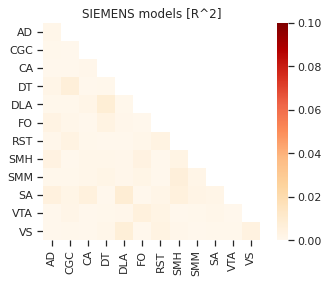

In [34]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[siemens_idx, 'mri_info_manufacturersmn']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('SIEMENS models [R^2]')
plt.show()

mean: 0.0160, max: 0.0525


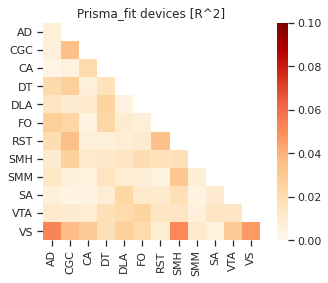

In [35]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[scan['mri_info_manufacturersmn'] == 'Prisma_fit',
             'mri_info_deviceserialnumber']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Prisma_fit devices [R^2]')
plt.show()

#### GE

In [36]:
ge_idx = scan['mri_info_manufacturer'].str.startswith('GE')

In [37]:
scan.loc[ge_idx, 'mri_info_manufacturersmn'].value_counts()

DISCOVERY MR750    2087
Name: mri_info_manufacturersmn, dtype: int64

In [38]:
scan.loc[ge_idx, 'mri_info_softwareversion'].value_counts()

25\LX\MR Software release:DV25.0_R02_1549.b    944
27\LX\MR Software release:DV26.0_R02_1810.b    539
27\LX\MR Software release:DV26.0_R01_1725.a    468
27\LX\MR Software release:DV26.0_R03_1831.b    109
27\LX\MR Software release:DV25.1_R01_1617.b     25
27\LX\MR Software release:DV26.0_EB_1707.b       2
Name: mri_info_softwareversion, dtype: int64

mean: 0.0074, max: 0.0364


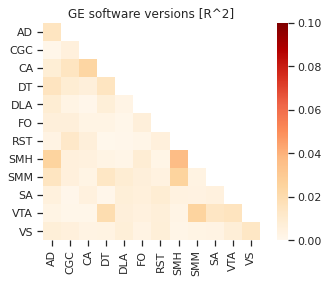

In [39]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[ge_idx, 'mri_info_softwareversion']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('GE software versions [R^2]')
plt.show()

mean: 0.0123, max: 0.0400


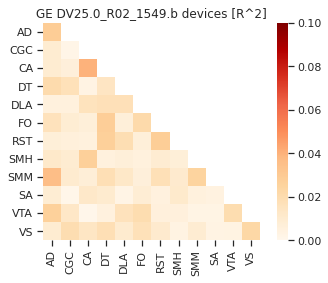

In [40]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[scan['mri_info_softwareversion'].str.endswith('DV25.0_R02_1549.b'),
             'mri_info_deviceserialnumber']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('GE DV25.0_R02_1549.b devices [R^2]')
plt.show()

#### Philips

In [41]:
philips_idx = scan['mri_info_manufacturer'].str.startswith('Philips')

In [42]:
scan.loc[philips_idx, 'mri_info_manufacturersmn'].value_counts()

Achieva dStream    630
Ingenia            368
Name: mri_info_manufacturersmn, dtype: int64

In [43]:
scan.loc[philips_idx, 'mri_info_softwareversion'].value_counts()

5.3.0\5.3.0.0    295
5.3.1\5.3.1.0    153
5.4.0\5.4.0.1    127
5.3.0\5.3.0.3    121
5.4.1\5.4.1.1    114
5.3.1\5.3.1.2     99
5.3.1\5.3.1.1     61
5.3.1\5.3.1.3     28
Name: mri_info_softwareversion, dtype: int64

/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mean: 0.0068, max: 0.0343


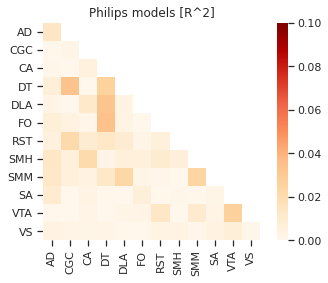

In [44]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[philips_idx, 'mri_info_manufacturersmn']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Philips models [R^2]')
plt.show()

mean: 0.0173, max: 0.0524


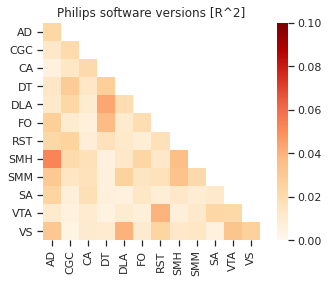

In [45]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[philips_idx, 'mri_info_softwareversion']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Philips software versions [R^2]')
plt.show()

#### Single-site

In [46]:
scan.loc[scan['site_id'] == 'site04'].value_counts()

mri_info_manufacturer  mri_info_manufacturersmn  mri_info_deviceserialnumber  mri_info_softwareversion                     site_id
GE MEDICAL SYSTEMS     DISCOVERY MR750           HASH4b0b8b05                 25\LX\MR Software release:DV25.0_R02_1549.b  site04     223
                                                                              27\LX\MR Software release:DV26.0_R02_1810.b  site04     212
                                                 HASHfeb7e81a                 25\LX\MR Software release:DV25.0_R02_1549.b  site04     126
                                                                              27\LX\MR Software release:DV26.0_R02_1810.b  site04     101
dtype: int64

mean: 0.0018, max: 0.0104


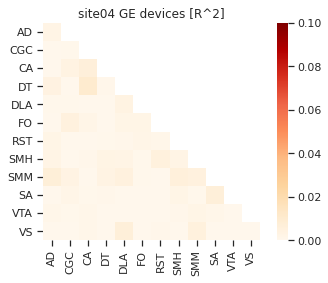

In [47]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[scan['site_id'] == 'site04', 'mri_info_deviceserialnumber']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('site04 GE devices [R^2]')
plt.show()

mean: 0.0062, max: 0.0422


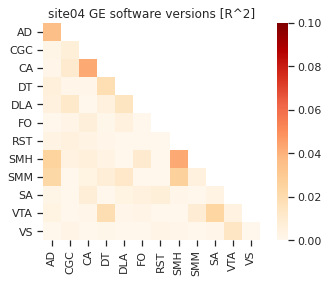

In [48]:
residresult = confound_residuals(
    fcon, sm.OLS,
    scan.loc[scan['site_id'] == 'site04', 'mri_info_softwareversion']
)
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('site04 GE software versions [R^2]')
plt.show()

### Best set by adjusted R2 (LONG)

In [13]:
def powerset(iterable):
    from itertools import chain, combinations
    
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, 1 + len(s)))

def adjusted_r2s(confound_set):
    residresult = confound_residuals(fcon, sm.OLS, scan[list(confound_set)])
    adj_r2s = residresult['results'].apply(lambda r: r.rsquared_adj)
    return adj_r2s.rename(str(confound_set))

from joblib import Parallel, delayed

adj_r2s = Parallel(n_jobs=4)(delayed(adjusted_r2s)(c) for c in powerset(scan.columns))
adj_r2s = pd.concat(adj_r2s, axis=1).T

In [22]:
adj_r2s.mean(axis=1).sort_values(ascending=False).head()

('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')                  0.028104
('mri_info_deviceserialnumber', 'mri_info_softwareversion')                                           0.027991
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion', 'site_id')    0.027897
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')               0.027871
('mri_info_softwareversion', 'site_id')                                                               0.027851
dtype: float64

In [23]:
adj_r2s.median(axis=1).sort_values(ascending=False).head()

('mri_info_deviceserialnumber', 'mri_info_softwareversion')                                                         0.022204
('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')                                0.021932
('mri_info_softwareversion', 'site_id')                                                                             0.021571
('mri_info_manufacturer', 'mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')    0.021491
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')                             0.021397
dtype: float64

In [24]:
adj_r2s.max(axis=1).sort_values(ascending=False).head()

('mri_info_softwareversion', 'site_id')                                                         0.134506
('mri_info_deviceserialnumber',)                                                                0.134483
('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')         0.134395
('mri_info_manufacturer', 'mri_info_manufacturersmn', 'mri_info_softwareversion', 'site_id')    0.134173
('mri_info_deviceserialnumber', 'mri_info_softwareversion')                                     0.134103
dtype: float64

### Site

In [8]:
residresults = {}

curr_features = fcon
for scan_conf in ['mri_info_deviceserialnumber', 'mri_info_softwareversion', 'site_id']:
    residresults[scan_conf] = confound_residuals(curr_features, sm.OLS, scan[scan_conf])
    curr_features = residresults[scan_conf]['resids']

/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mean: 0.0304, max: 0.1375


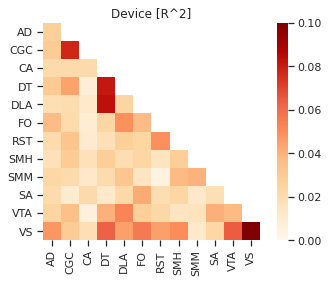

In [11]:
r2s = residresults['mri_info_deviceserialnumber']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Device [R^2]')
plt.show()

mean: 0.0023, max: 0.0114


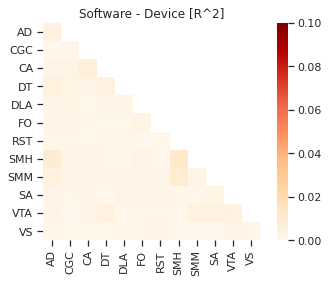

In [12]:
r2s = residresults['mri_info_softwareversion']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Software - Device [R^2]')
plt.show()

mean: 0.0002, max: 0.0008


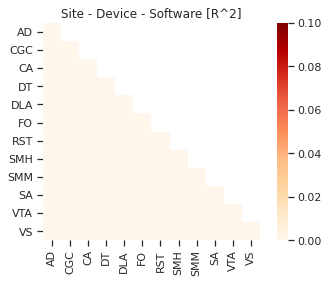

In [13]:
r2s = residresults['site_id']['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Site - Device - Software [R^2]')
plt.show()

## Motion

/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mean: 0.0116, max: 0.0875


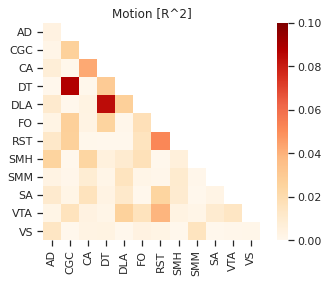

In [6]:
residresult = confound_residuals(fcon, sm.OLS, fc_extra['rsfmri_c_ngd_meanmotion'])
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Motion [R^2]')
plt.show()

## Demographic

In [54]:
demo = covariates.loc[fcon.index, [
    'sex', 'race', 'hisp', 'married', 'comb_income.3level', 'highest_ed.5level'
]]

mean: 0.0032, max: 0.0206


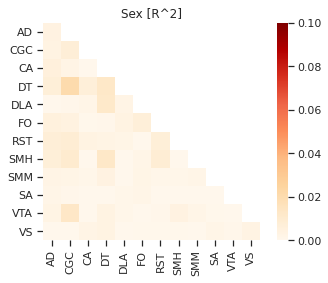

In [55]:
residresult = confound_residuals(fcon, sm.OLS, demo['sex'])
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Sex [R^2]')
plt.show()

mean: 0.0079, max: 0.0438


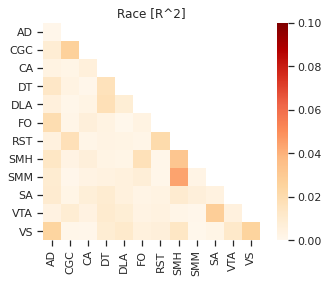

In [57]:
residresult = confound_residuals(fcon, sm.OLS, demo[['race', 'hisp']])
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Race [R^2]')
plt.show()

mean: 0.0025, max: 0.0164


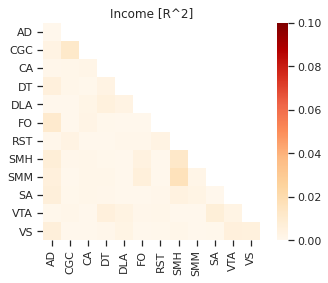

In [58]:
freq_code = demo['comb_income.3level'].value_counts() / len(demo)
residresult = confound_residuals(fcon, sm.OLS, demo['comb_income.3level'].map(freq_code).dropna())
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Income [R^2]')
plt.show()

mean: 0.0022, max: 0.0162


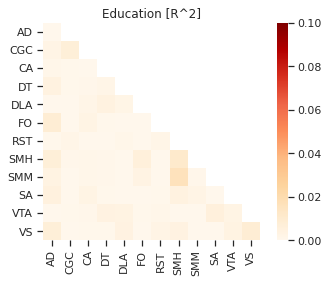

In [59]:
freq_code = demo['highest_ed.5level'].value_counts() / len(demo)
residresult = confound_residuals(fcon, sm.OLS, demo['highest_ed.5level'].map(freq_code).dropna())
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Education [R^2]')
plt.show()

mean: 0.0030, max: 0.0157


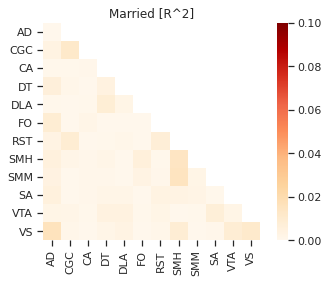

In [60]:
residresult = confound_residuals(fcon, sm.OLS, demo['married'].dropna())
r2s = residresult['results'].apply(lambda r: r.rsquared)

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(r2s, cmap='OrRd', vmax=0.10, vmin=0)
ax.set_title('Married [R^2]')
plt.show()

# Structural connectivity

In [7]:
scon, sc_extra = abcd.load_mri_data(ABCD_PATH, 'scon', dropna=True)

subs = scon.index.get_level_values(0).unique()
print(len(subs), 'subjects')

4639 subjects


## Scanner

In [26]:
# fill in some baseline NA with year2
scan = sc_extra[abcd.SCAN_INFO].join(covariates['site_id']).fillna(method='bfill')

### Progressive residualize

In [27]:
residresults = {}

curr_features = scon
for scan_conf in abcd.SCAN_INFO:
    residresults[scan_conf] = confound_residuals(curr_features, sm.OLS, scan[scan_conf])
    curr_features = residresults[scan_conf]['resids']

/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
r2ss = [residresults[scan_conf]['results'].apply(lambda r: r.rsquared)
       for scan_conf in abcd.SCAN_INFO]
r2ss = pd.concat(r2ss, axis=1, keys=['Manufact', 'Model', 'Device', 'Software']).T

In [29]:
for conf, r2s in r2ss.iterrows():
    print(f'{conf:9} | mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

Manufact  | mean: 0.2171, max: 0.3730
Model     | mean: 0.0164, max: 0.0547
Device    | mean: 0.0403, max: 0.0622
Software  | mean: 0.0153, max: 0.0422


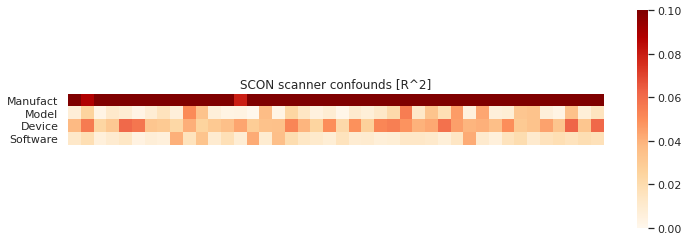

In [31]:
fig, ax = plt.subplots(figsize=(12,4))

ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SCON scanner confounds [R^2]')
ax.set_xticks([])
plt.show()

### Best set by adjusted R2 (LONG)

In [83]:
def powerset(iterable):
    from itertools import chain, combinations
    
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, 1 + len(s)))

def adjusted_r2s(confound_set):
    residresult = confound_residuals(scon, sm.OLS, scan[list(confound_set)])
    adj_r2s = residresult['results'].apply(lambda r: r.rsquared_adj)
    return adj_r2s.rename(str(confound_set))

from joblib import Parallel, delayed

adj_r2s = Parallel(n_jobs=4)(delayed(adjusted_r2s)(c) for c in powerset(scan.columns))
adj_r2s = pd.concat(adj_r2s, axis=1).T

/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/kimsin98/miniconda3/envs/StructFunc/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.co

In [84]:
adj_r2s.mean(axis=1).sort_values(ascending=False).head()

('mri_info_deviceserialnumber', 'mri_info_softwareversion')         0.268354
('mri_info_softwareversion', 'site_id')                             0.267648
('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')    0.263190
('mri_info_deviceserialnumber',)                                    0.258793
('mri_info_manufacturersmn', 'site_id')                             0.253027
dtype: float64

In [85]:
adj_r2s.median(axis=1).sort_values(ascending=False).head()

('mri_info_deviceserialnumber', 'mri_info_softwareversion')         0.256059
('mri_info_softwareversion', 'site_id')                             0.254441
('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')    0.253737
('mri_info_deviceserialnumber',)                                    0.246381
('mri_info_manufacturersmn', 'site_id')                             0.241376
dtype: float64

In [86]:
adj_r2s.max(axis=1).sort_values(ascending=False).head()

('mri_info_deviceserialnumber', 'mri_info_softwareversion')            0.416228
('mri_info_softwareversion', 'site_id')                                0.415636
('mri_info_manufacturer', 'mri_info_softwareversion', 'site_id')       0.409358
('mri_info_deviceserialnumber',)                                       0.404808
('mri_info_manufacturersmn', 'mri_info_softwareversion', 'site_id')    0.401176
dtype: float64

## Motion

mean: 0.0544, max: 0.1310


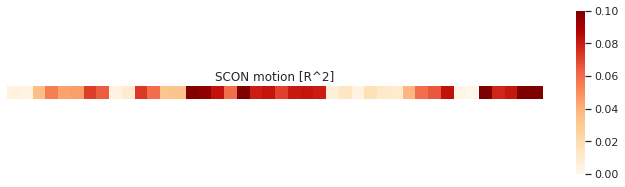

In [15]:
residresult = confound_residuals(scon, sm.OLS, sc_extra['dmri_dti_meanmotion'])
r2s = residresult['results'].apply(lambda r: r.rsquared)
r2ss = pd.DataFrame(r2s.rename('Motion')).T

print(f'mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

fig, ax = plt.subplots(figsize=(12,3))

ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SCON motion [R^2]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Demographic

In [32]:
demo = covariates.loc[fcon.index, [
    'sex', 'race', 'hisp', 'married', 'comb_income.3level', 'highest_ed.5level'
]]

In [33]:
r2ss = []

residresult = confound_residuals(scon, sm.OLS, demo['sex'])
r2s = residresult['results'].apply(lambda r: r.rsquared)
r2ss.append(r2s.rename('Sex'))

residresult = confound_residuals(scon, sm.OLS, demo[['race', 'hisp']])
r2s = residresult['results'].apply(lambda r: r.rsquared)
r2ss.append(r2s.rename('Race'))

freq_code = demo['comb_income.3level'].value_counts() / len(demo)
residresult = confound_residuals(scon, sm.OLS, demo['comb_income.3level'].map(freq_code).dropna())
r2s = residresult['results'].apply(lambda r: r.rsquared)
r2ss.append(r2s.rename('Income'))

freq_code = demo['highest_ed.5level'].value_counts() / len(demo)
residresult = confound_residuals(scon, sm.OLS, demo['highest_ed.5level'].map(freq_code).dropna())
r2s = residresult['results'].apply(lambda r: r.rsquared)
r2ss.append(r2s.rename('Education'))

residresult = confound_residuals(scon, sm.OLS, demo['married'].dropna())
r2s = residresult['results'].apply(lambda r: r.rsquared)
r2ss.append(r2s.rename('Married'))

r2ss = pd.concat(r2ss, axis=1).T

In [34]:
for conf, r2s in r2ss.iterrows():
    print(f'{conf:9} | mean: {r2s.mean():.4f}, max: {r2s.max():.4f}')

Sex       | mean: 0.0022, max: 0.0115
Race      | mean: 0.0082, max: 0.0216
Income    | mean: 0.0007, max: 0.0033
Education | mean: 0.0006, max: 0.0042
Married   | mean: 0.0008, max: 0.0029


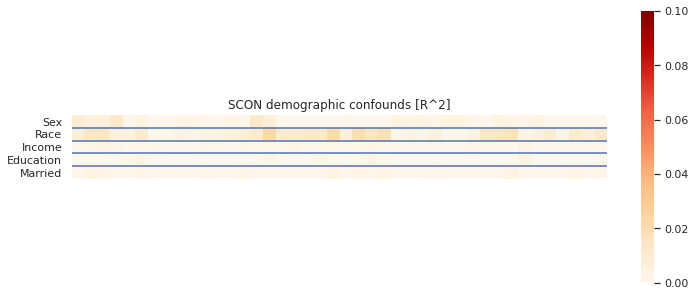

In [37]:
fig, ax = plt.subplots(figsize=(12,5))

ax = sns.heatmap(r2ss, square=True, cmap='OrRd', vmax=0.10, vmin=0, ax=ax)
ax.set_title('SCON demographic confounds [R^2]')
ax.set_xticks([])
ax.hlines(np.arange(1, len(r2ss)), *ax.get_xlim())
plt.show()

# TODO

* bootstrap + violin plot
* methods
    * ComBat (empirical Bayesian)
    * Hierarchical Bayesian

[Marek-IdentifyingReproducible-2019](https://doi.org/10.1016/j.dcn.2019.100706) Replication
* subject similarity
* multidimensional scaling

## Statistics
1. How to measure confounding?
    * Compare metrics.
    * Confidence interval
2. How to aggregate scores across multiple features?
3. How to score and choose confounds? (effect vs model size)
    * Dimension reduction
        * max relevance minimum redundancy
        * mutual information
        * recursive feature elimination